# Saudi Used Cars Project

This is the third capstone project of the Bootcamp Data Science and Machine Learning at DTI Purwadhika. The goal of the project is to predict the price of a used car based on its features.



# Business Problem Understanding

## Context
A dataset of used cars in Saudi Arabia with various features like make, model, year, mileage, and price. The goal is to analyze the factors affecting car prices and build a model to predict used car prices accurately, helping both buyers and sellers make informed decisions in the used car market.

## Problem Statement
The used car market faces several challenges:
1. Price uncertainty leads to inefficient negotiations and potential financial losses
2. Many factors influence car prices (age, mileage, brand, etc.), making manual estimation difficult
3. Market participants lack reliable tools to validate car valuations
4. Time and resources are wasted in price negotiations due to information asymmetry

## Goals
1. Develop an accurate price prediction model to:
   - Help sellers set competitive yet fair prices
   - Help buyers evaluate if asking prices are reasonable
   - Reduce negotiation time and friction in transactions
2. Identify key factors that influence used car prices in Saudi Arabia
3. Compare different machine learning approaches to find the most reliable prediction method

## Analytic Approach
1. Data Analysis:
   - Analyze relationships between features and price
   - Identify patterns and trends in the market
   - Handle missing values and outliers appropriately

2. Model Development:
   We'll test multiple regression models:
   - Linear Regression (baseline model)
   - Ridge
   - Lasso
   - Random Forest Regressor
   - XGBoost Regressor
   - LightGBM Regressor
   
3. Model Comparison:
   - Compare models using multiple metrics
   - Analyze trade-offs between complexity and accuracy
   - Select the best model based on performance and practicality

## Metric Evaluation
We'll use multiple metrics to ensure robust model evaluation:

Primary Metrics:
- R² Score: To measure the model's explanatory power
- RMSE (Root Mean Square Error): To measure prediction accuracy in actual price terms
- MAE (Mean Absolute Error): To measure average prediction error

Secondary Considerations:
- Model training time
- Prediction speed
- Model interpretability
- Feature importance analysis

The final model selection will balance prediction accuracy with practical considerations like computation speed and interpretability.

In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, TargetEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
warnings.filterwarnings('ignore')

## Data Loading and Initial Exploration

In [421]:
# 1. Data Loading and Initial Exploration
df = pd.read_csv('data/data_saudi_used_cars.csv')

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
display(df.describe(include='all'))


Dataset Shape: (5624, 11)

Missing Values:
 Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5624,5624,5624,5624,5624,5624,5624.000000,5624.000000,5.624000e+03,5624,5624.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2272,1431,4875,4188,2233,NaN,NaN,NaN,3828,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.101885,3.295430,1.509234e+05,NaN,53074.058144
std,NaN,NaN,NaN,NaN,NaN,NaN,5.791606,1.515108,3.828360e+05,NaN,70155.340614
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,72932.500000


We can see following points in the statistic description:

- There are 1797 rows with price = 0, which is not a valid price.

- `Type`, `Region`, `Make` are categorical features that have high cardinality

- `Options` is an ordinal (Standard, Semi Full, Full) feature that has low cardinality

- `Gear_Type` is categorical (Automatic, Manual) feature that has low cardinality


In [422]:
numerical_features = ['Year', 'Mileage', 'Engine_Size']
categorical_features = ['Make', 'Model', 'Type', 'Origin', 'Gear_Type', 'Options', 'Region']

#### Drop duplicates

In [423]:
display("Duplicated rows:", df.duplicated().sum())

df = df.drop_duplicates()

display("Duplicated rows now:", df.duplicated().sum())

'Duplicated rows:'

4

'Duplicated rows now:'

0

## Feature Engineering and Feature Selection

### Cars with price = 0


We have around 1797 cars with price = 0. Since this is not valid price, as far as modelling is concerned, these prices will make the model biased, and the data will be skewed for price prediction model.

Let's see the distribution of the cars with price = 0.


In [424]:
display(df[df['Price'] == 0].describe(include='all'))

# Calculate percentage of negotiable prices
negotiable_pct = (df['Negotiable'].sum() / len(df)) * 100
print(f"\nPercentage of negotiable prices in original dataset: {negotiable_pct:.2f}%")

df_zero_price = df[df['Price'] == 0]
df = df[df['Price'] != 0]

display(df_zero_price['Negotiable'].value_counts())


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,1796,1796,1796,1796,1796,1796,1796.000000,1796.000000,1.796000e+03,1796,1796.0
unique,221,27,43,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,True,NaN
freq,121,655,541,1451,1291,759,NaN,NaN,NaN,1795,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2012.501670,3.541537,1.685968e+05,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,6.757189,1.601942,3.920362e+05,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,1965.000000,1.000000,1.000000e+02,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,2.400000,1.575000e+04,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,3.500000,1.000000e+05,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,4.600000,2.220000e+05,NaN,0.0



Percentage of negotiable prices in original dataset: 31.94%


Negotiable
True     1795
False       1
Name: count, dtype: int64

As you can see, almost all of the cars with price = 0 are negotiable. It does not introduce variability in the data, i.e. not a good predictor. Thus, we'll drop these rows for now.


## Numerical Features Correlation

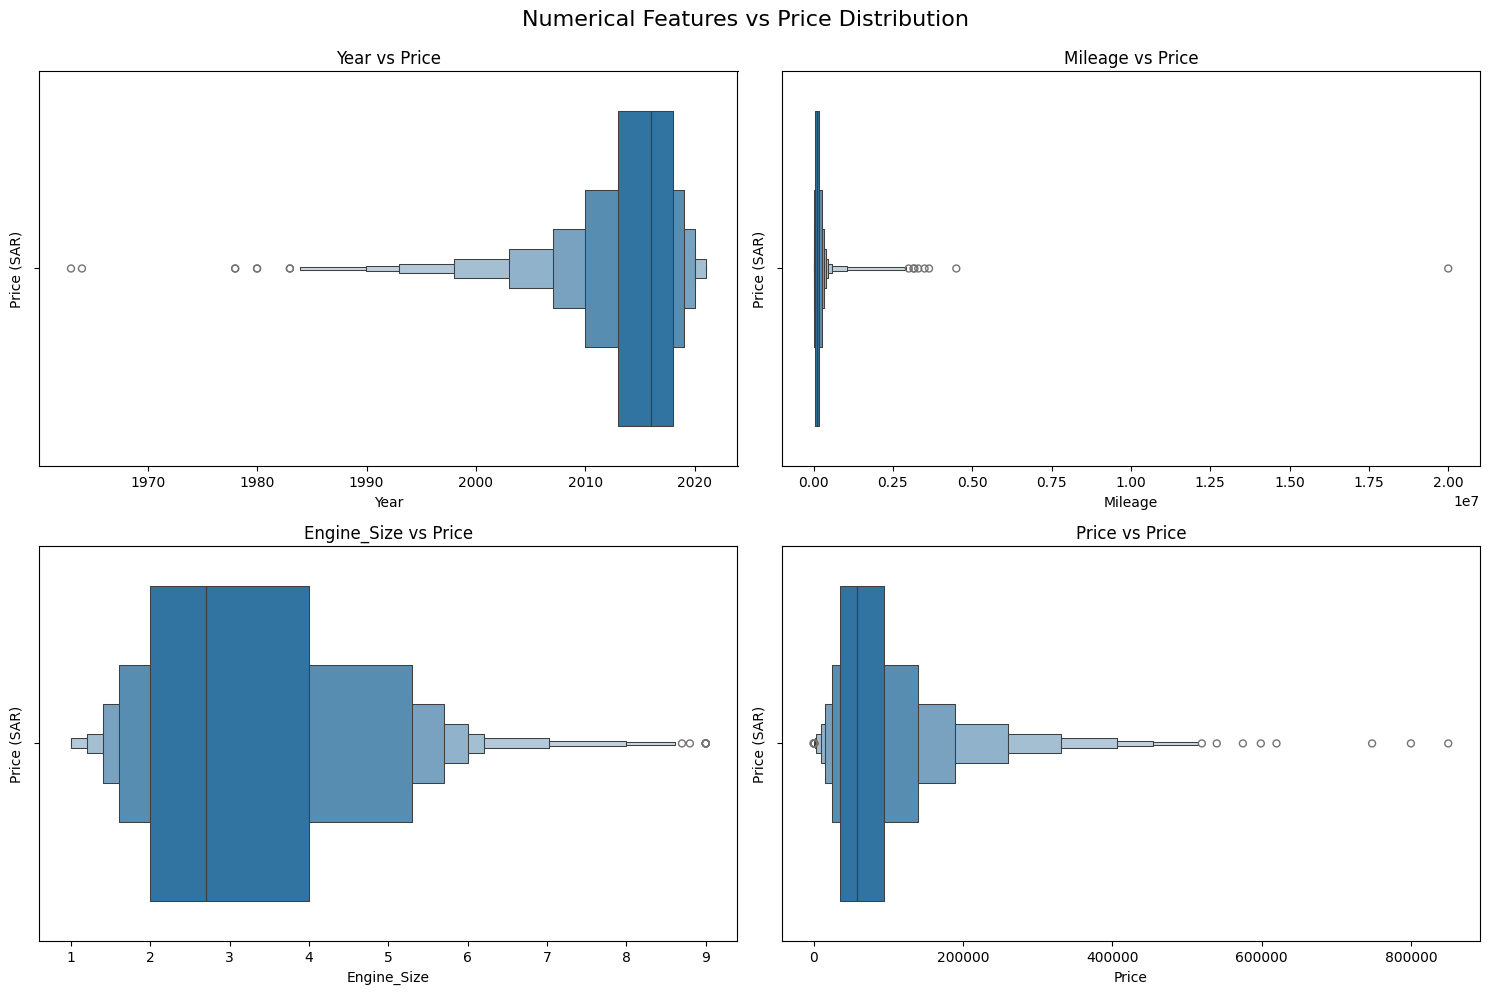

In [425]:
all_numerical_features = numerical_features + ['Price']

# create boxplot for numerical features
fig, axes = plt.subplots(2, 2, figsize=(15,  10))
fig.suptitle('Numerical Features vs Price Distribution', fontsize=16, y=0.99)

for idx, feature in enumerate(all_numerical_features):
    row = idx // 2
    col = idx % 2

    sns.boxenplot(data=df, x=feature, ax=axes[row, col])
    
    axes[row, col].set_title(f'{feature} vs Price')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()


There is strange outlier in `Mileage`, the values seems odd `20.000.000` if we compare to other high mileage cars.

Let's drop this row for now, as it's too high even compared to other high mileage cars.


In [426]:
def remove_outliers(df, columns, n_std=3):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df = df[np.abs(df[col] - mean) <= (n_std * std)]
    return df

df = remove_outliers(df, numerical_features)

df.describe(include='all')
# df = df[df['Mileage'] < 20000000]
# df[df['Mileage'] > 1000000].sort_values(by='Mileage', ascending=False)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,3713,3713,3713,3713,3713,3713,3713.000000,3713.000000,3.713000e+03,3713,3713.000000
unique,313,27,55,2,4,3,NaN,NaN,NaN,1,NaN
top,Accent,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,147,1584,858,3347,2824,1417,NaN,NaN,NaN,3713,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2015.329383,3.136332,1.270786e+05,NaN,78919.631834
std,NaN,NaN,NaN,NaN,NaN,NaN,3.910783,1.398333,1.095692e+05,NaN,72651.441570
min,NaN,NaN,NaN,NaN,NaN,NaN,2000.000000,1.000000,1.000000e+02,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,2.000000,4.900000e+04,NaN,36000.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,1.021090e+05,NaN,58500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.000000,1.800000e+05,NaN,95000.000000


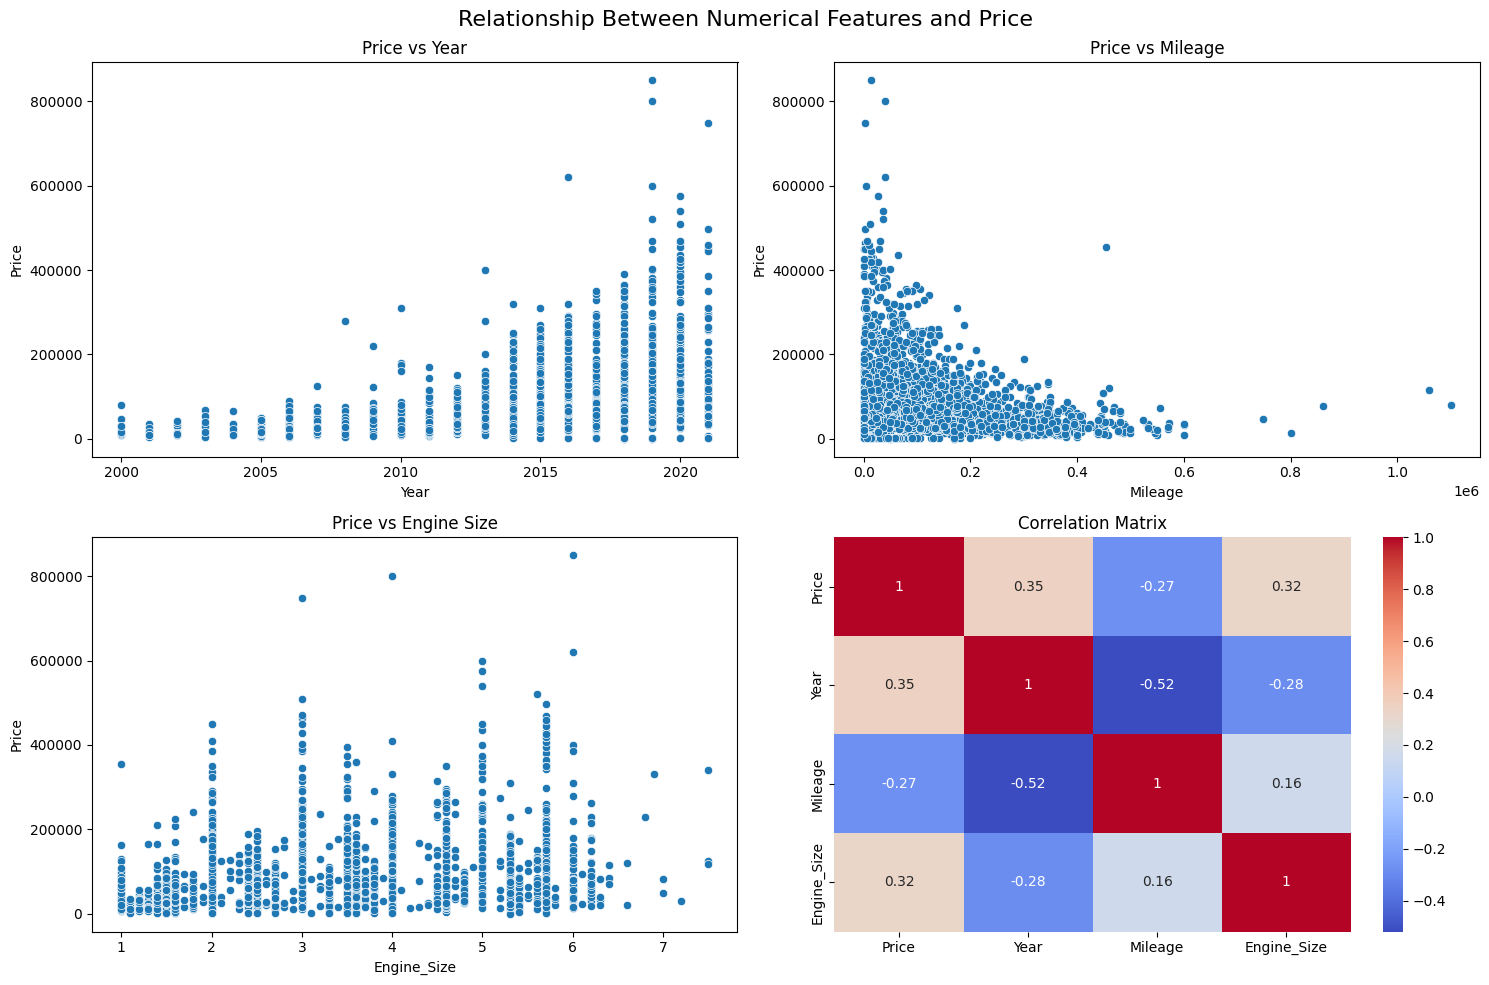


Correlation with Price:
Year: 0.349
Mileage: -0.274
Engine_Size: 0.323


In [427]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Relationship Between Numerical Features and Price', fontsize=16)

# Plot Price vs Year
sns.scatterplot(data=df[df['Price'] > 0], x='Year', y='Price', ax=axes[0,0])
axes[0,0].set_title('Price vs Year')

# Plot Price vs Mileage
sns.scatterplot(data=df[df['Price'] > 0], x='Mileage', y='Price', ax=axes[0,1])
axes[0,1].set_title('Price vs Mileage')

# Plot Price vs Engine_Size
sns.scatterplot(data=df[df['Price'] > 0], x='Engine_Size', y='Price', ax=axes[1,0])
axes[1,0].set_title('Price vs Engine Size')

# Calculate correlation
correlation_matrix = df[['Price', 'Year', 'Mileage', 'Engine_Size']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation values with Price
print("\nCorrelation with Price:")
for col in ['Year', 'Mileage', 'Engine_Size']:
    correlation = df[col].corr(df['Price'])
    print(f"{col}: {correlation:.3f}")

### Result

1. `Year vs Price`
    - Moderately positive correlation (0.31)
    - Almost linear with significant outliers (old cars and high price luxury cars)

2. `Mileage vs Price`
    - Negative weak correlation (-0.19)
    - Non linear

3. `Engine_Size vs Price`
    - Positive correlation (0.31)
    - Non linear correlation

Since both linear and non-linear correlation is present, we'll keep all of them, and to *assess* which model is the most suitable, together with categorical features.


## Categorical Features Correlation

Let's see the distribution of the price by each categorical feature.

### Boxplot distribution of price by each categorical feature

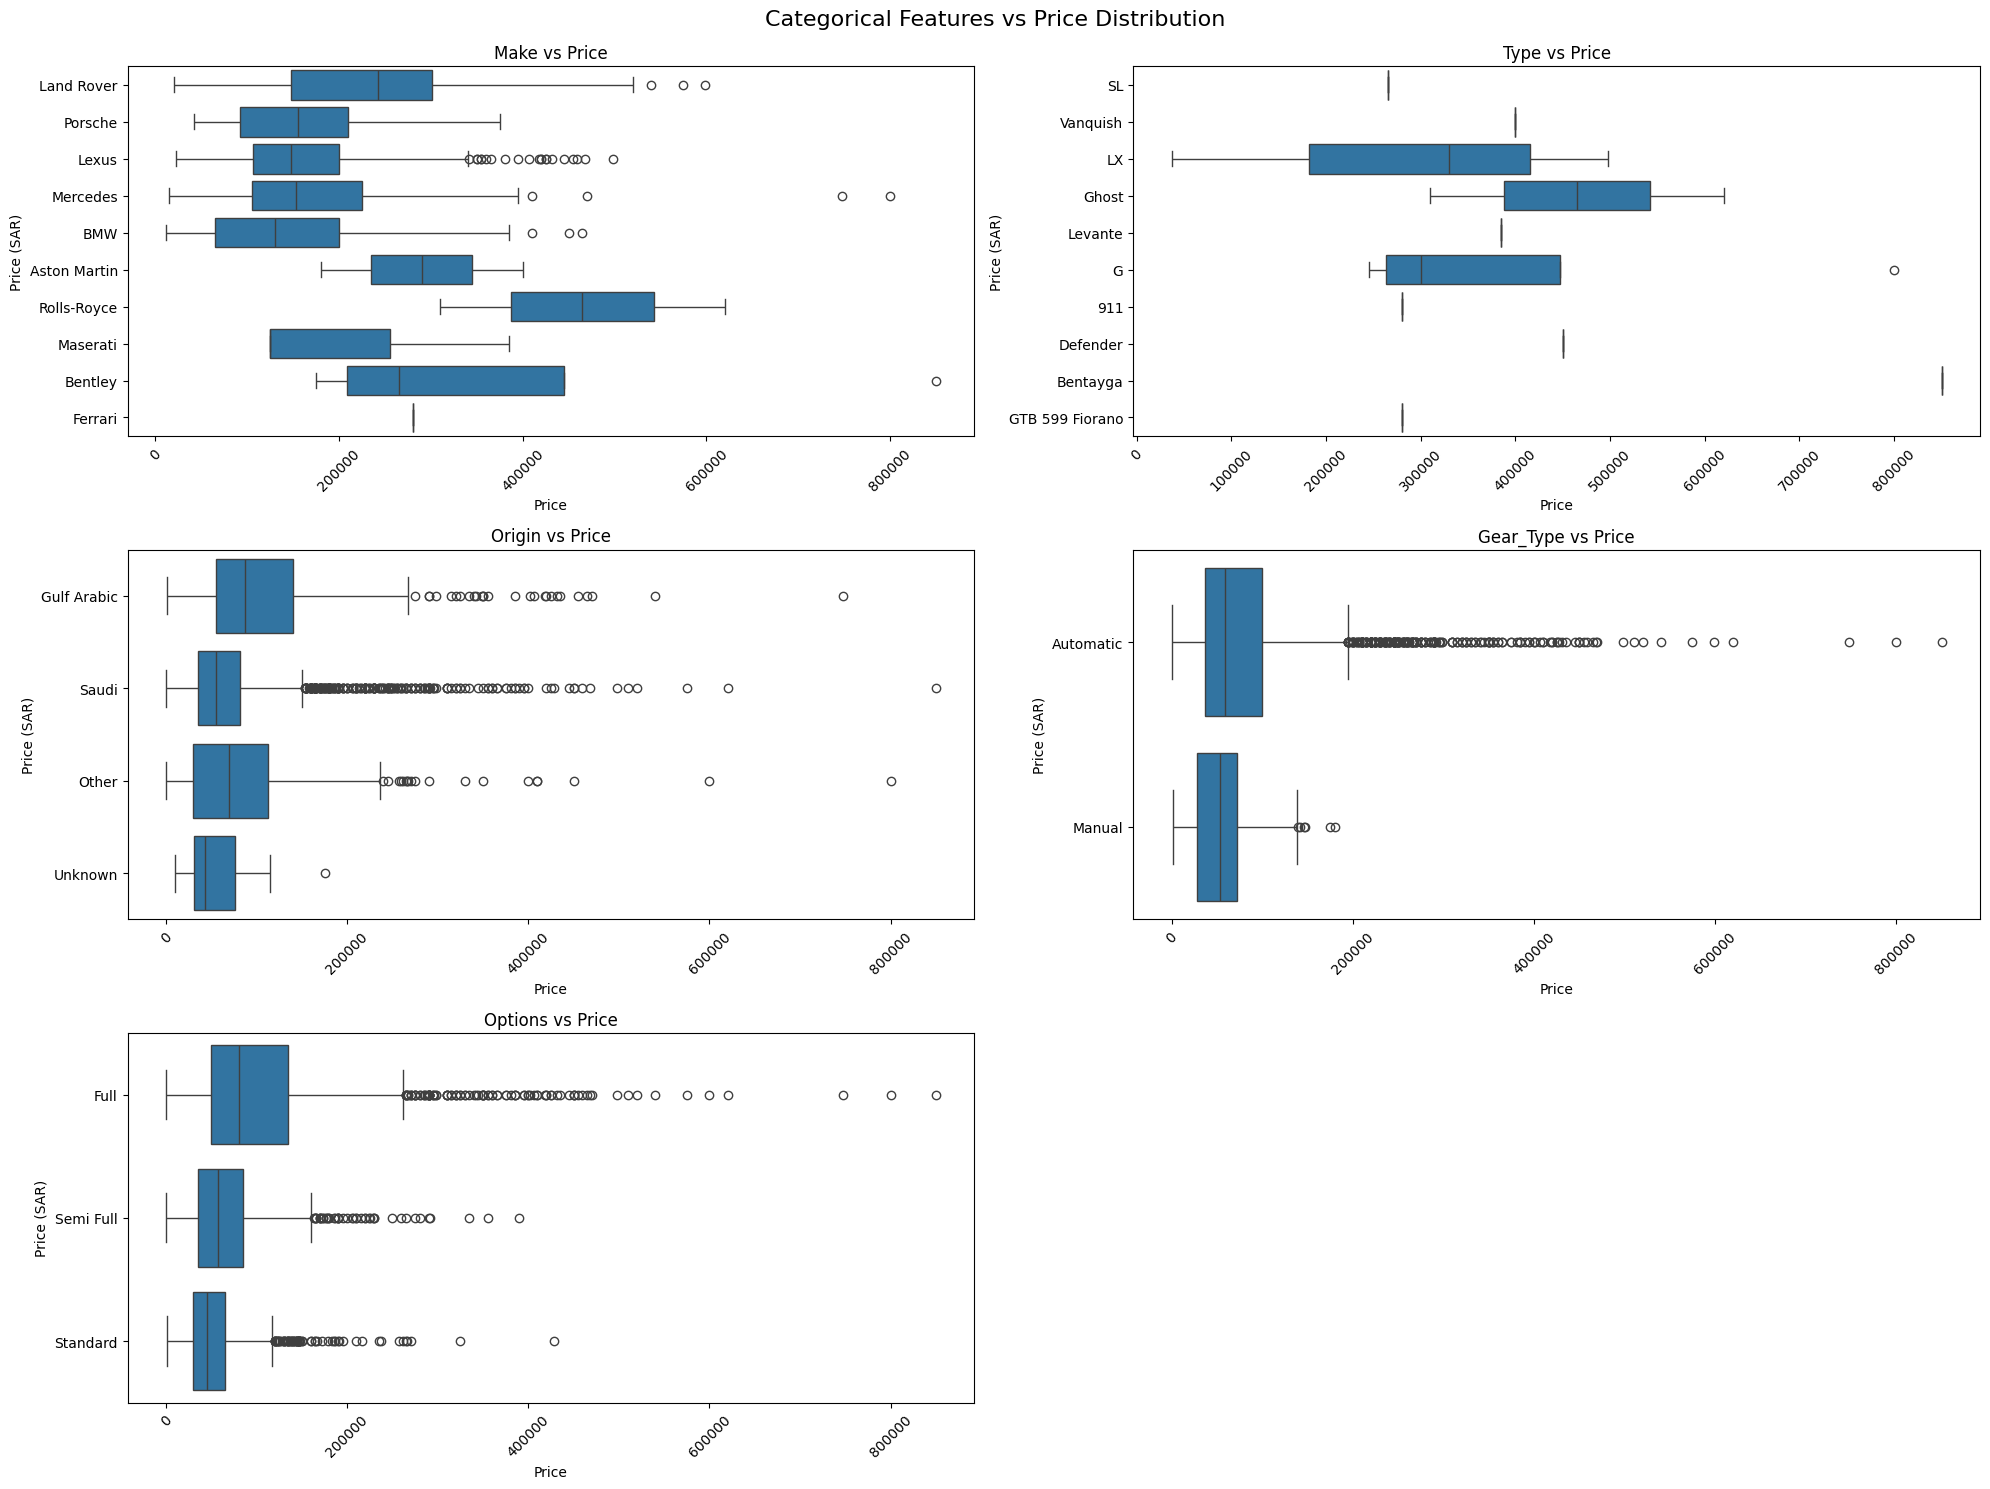

In [428]:
# Create boxplot for categorical features vs price
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Categorical Features vs Price Distribution', fontsize=16, y=0.99)

# Select top 4 categorical features based on their correlation
important_cats = ['Make', 'Type', 'Origin', 'Gear_Type', 'Options']

for idx, feature in enumerate(important_cats):
    row = idx // 2
    col = idx % 2
    
    if not (row == 2 and col == 1):
        # Calculate mean price for each category
        mean_prices = df.groupby(feature)['Price'].mean().sort_values(ascending=False).head(10)
        
        # Create bar plot
        sns.boxplot(data=df[df[feature].isin(mean_prices.index)], 
                    x='Price', y=feature,
                    ax=axes[row, col])
        
        axes[row, col].set_title(f'{feature} vs Price')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylabel('Price (SAR)')

axes[2, 1].set_visible(False)
plt.tight_layout()
plt.show()

## Data preprocessing

In [429]:
df_encoded = df.copy()
display(df_encoded)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,False,48000
...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000


### Encode categorical variables

Based on observation, we have 3 types of categorical features:

1. Ordinal features: `Options` -> this is showing a car's interior features: `standard`, `semi-full` and `full`

2. Low cardinality features: `Gear_Type`, `Origin`

3. High cardinality features: `Type`, `Region`, `Make`


### Scaling numerical features

We'll use `StandardScaler` to scale the target variable, since it's important for encoding categorical features


Scaled numerical features statistics:
           Year   Mileage  Engine_Size
count  3713.000  3713.000     3713.000
mean     -0.000     0.000       -0.000
std       1.000     1.000        1.000
min      -3.920    -1.159       -1.528
25%      -0.340    -0.713       -0.813
50%       0.172    -0.228       -0.312
75%       0.683     0.483        0.618
max       1.450     8.881        3.121


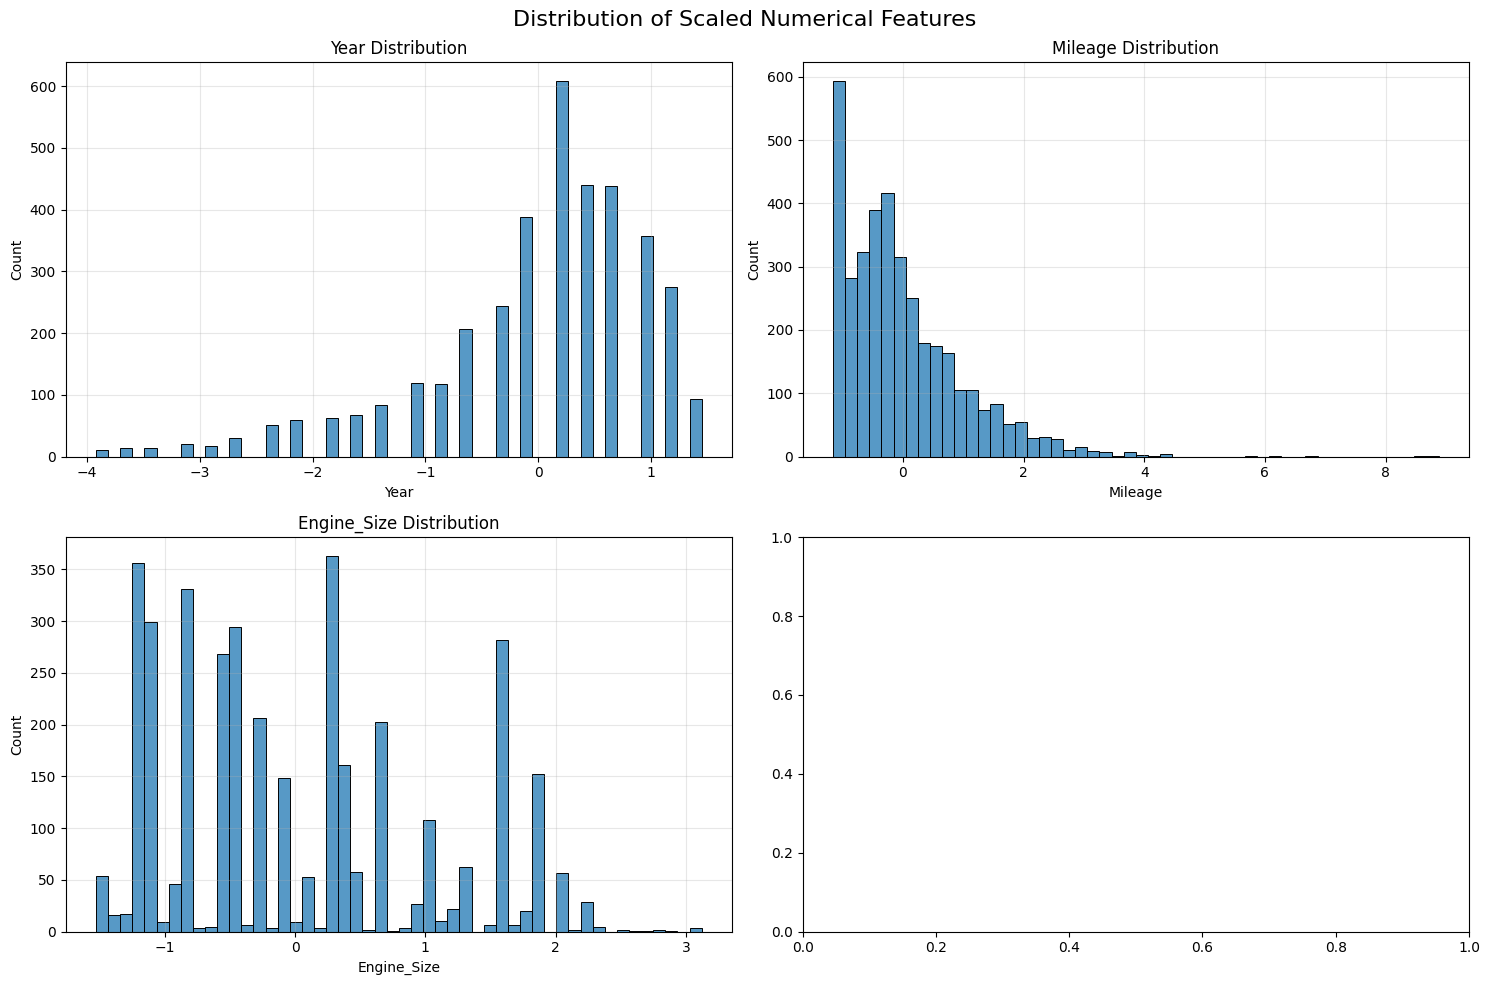

In [430]:
scaler = StandardScaler()
scaled_price = scaler.fit_transform(df[['Price']])

df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Verify the scaling
print("Scaled numerical features statistics:")
print(df_encoded[numerical_features].describe().round(3))

# Optional: Visualize the scaled distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Scaled Numerical Features', fontsize=16)

for idx, feature in enumerate(numerical_features):
    row = idx // 2
    col = idx % 2
    
    sns.histplot(data=df_encoded, x=feature, bins=50, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [431]:
# Handle categorical variables
ordinal_feature = 'Options'
low_cardinality_features = ['Gear_Type', 'Origin']
high_cardinality_features = ['Type', 'Region', 'Make']

# start the order from the lowest to the highest
options = ['Standard', 'Semi Full', 'Full']

encoders = {}
# Get one hot encoding for low cardinality features
df_encoded = pd.get_dummies(df_encoded, columns=low_cardinality_features, prefix=low_cardinality_features)

# Get ordinal encoding
ordinal = OrdinalEncoder(categories=[options])
df_encoded['Options'] = ordinal.fit_transform(df_encoded[[ordinal_feature]])

# Get target encoding for high cardinality features
for feature in high_cardinality_features:
    encoders[feature] = TargetEncoder()
    
    # Fit and transform on the same DataFrame
    df_encoded[feature] = encoders[feature].fit_transform(df[[feature]], scaled_price)


df_encoded

for feature in high_cardinality_features:
    print(f"\n{feature} encoding stats:")
    print(df_encoded[feature].describe())


Type encoding stats:
count    3713.000000
mean       -0.025096
std         0.659068
min        -1.066958
25%        -0.466945
50%        -0.195802
75%         0.145441
max         4.213565
Name: Type, dtype: float64

Region encoding stats:
count    3713.000000
mean        0.000664
std         0.155687
min        -0.879931
25%        -0.055393
50%         0.031500
75%         0.068926
max         0.246398
Name: Region, dtype: float64

Make encoding stats:
count    3713.000000
mean       -0.011678
std         0.583257
min        -1.069946
25%        -0.372540
50%        -0.153050
75%         0.025885
max         7.448624
Name: Make, dtype: float64


### Visualize the encoded feature distribution

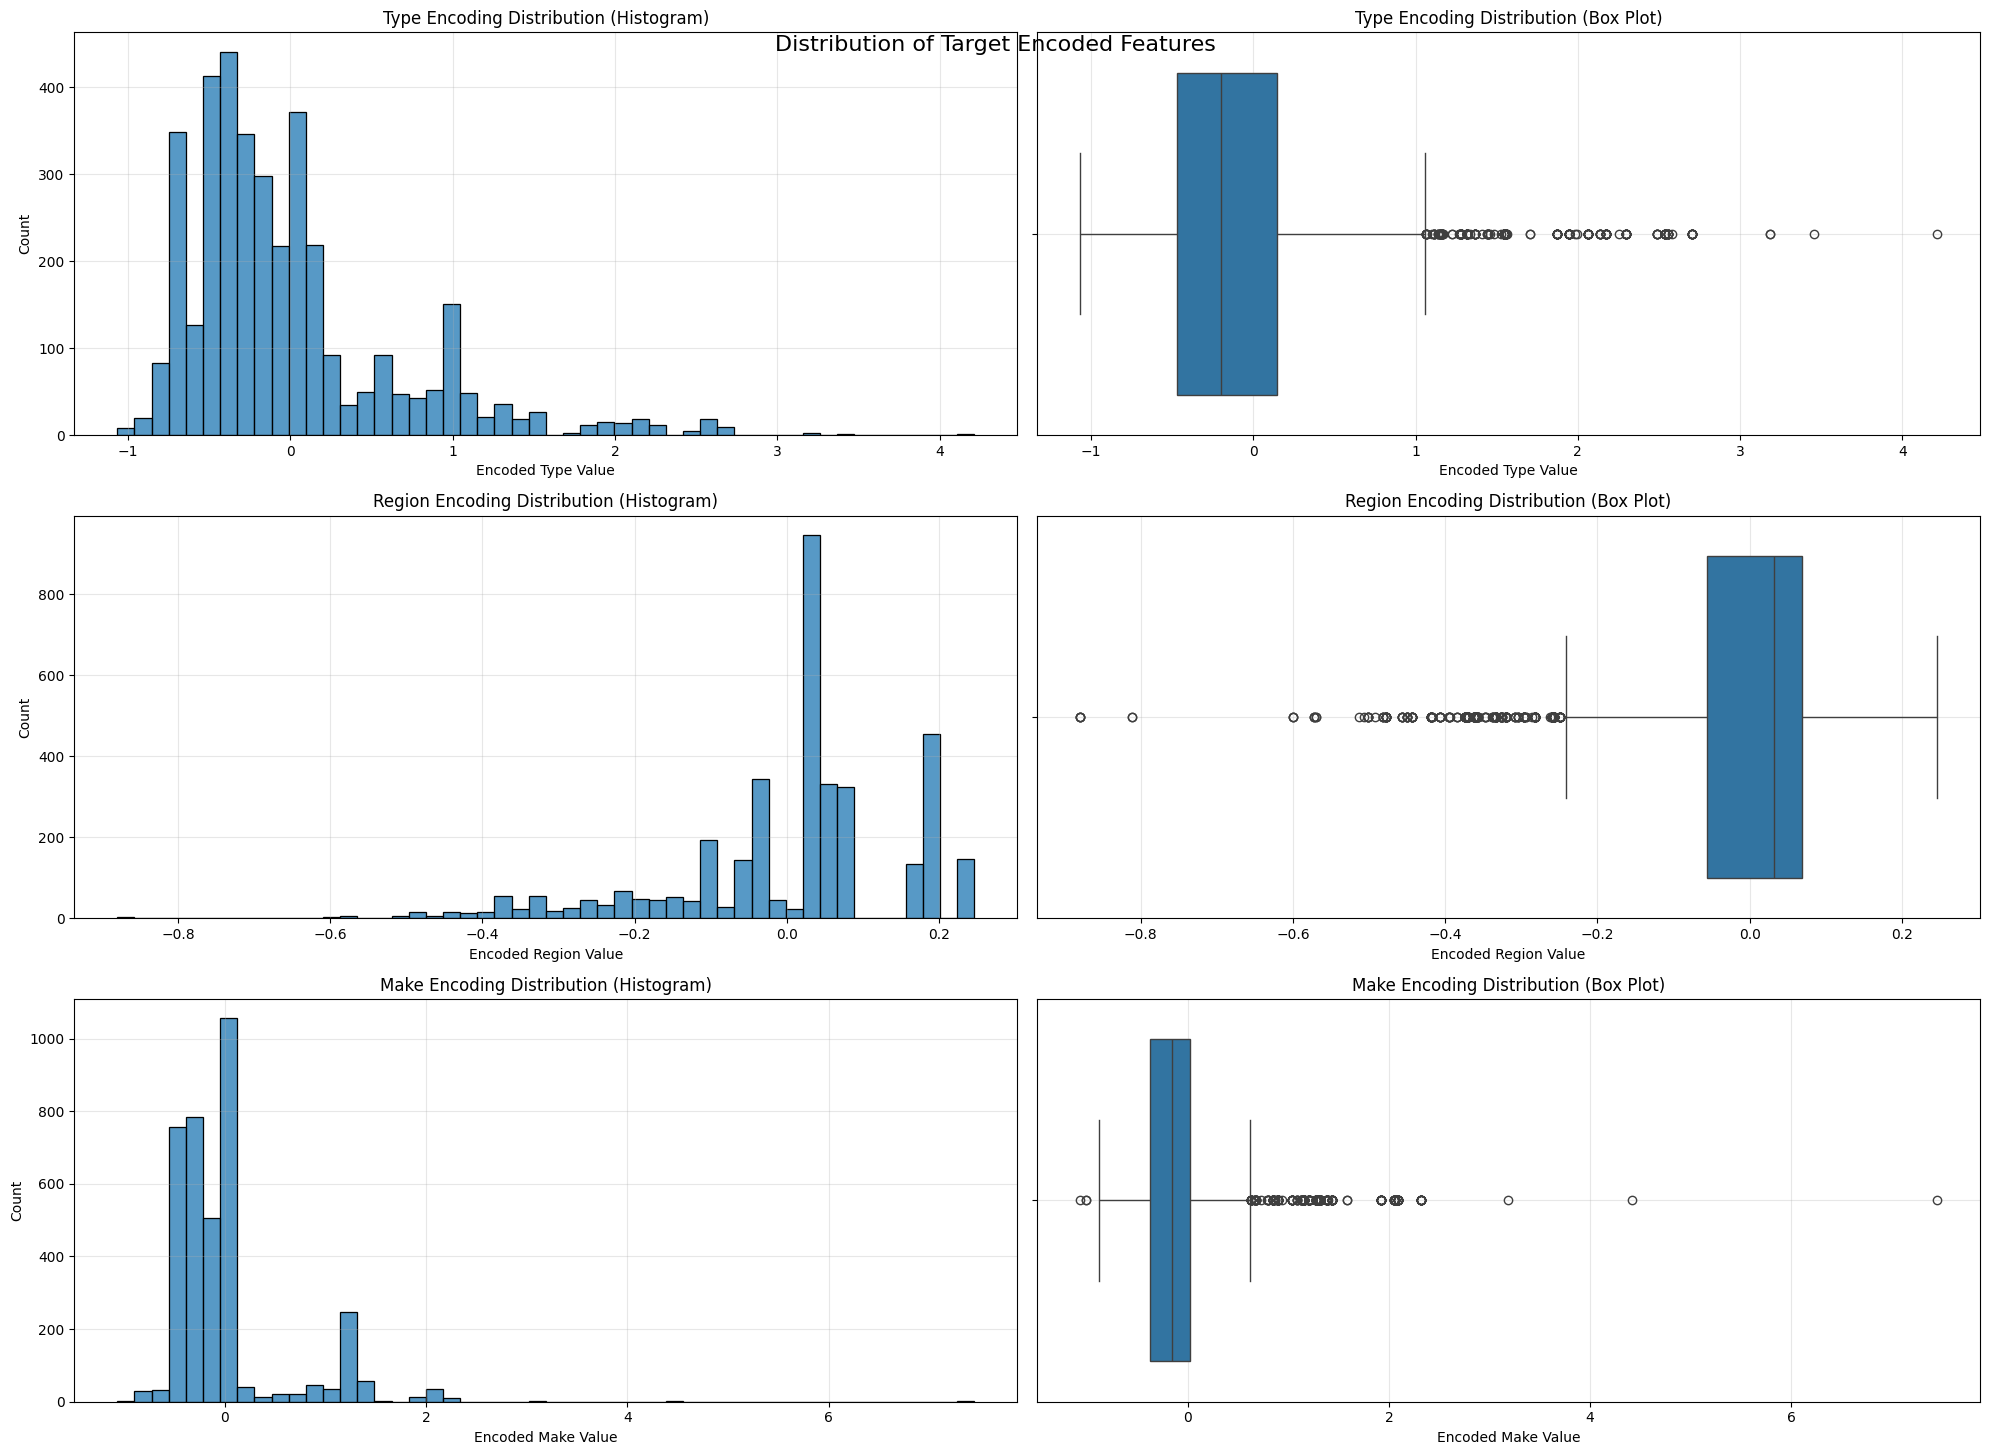


Type encoding stats:
count    3713.000
mean       -0.025
std         0.659
min        -1.067
25%        -0.467
50%        -0.196
75%         0.145
max         4.214
Name: Type, dtype: float64
Skewness: 1.694
Kurtosis: 3.442

Region encoding stats:
count    3713.000
mean        0.001
std         0.156
min        -0.880
25%        -0.055
50%         0.032
75%         0.069
max         0.246
Name: Region, dtype: float64
Skewness: -1.111
Kurtosis: 2.198

Make encoding stats:
count    3713.000
mean       -0.012
std         0.583
min        -1.070
25%        -0.373
50%        -0.153
75%         0.026
max         7.449
Name: Make, dtype: float64
Skewness: 2.388
Kurtosis: 10.625


In [432]:
# Create distribution plots for encoded features
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Distribution of Target Encoded Features', fontsize=16, y=0.95)

# List of encoded features
encoded_features = ['Type', 'Region', 'Make']

for idx, feature in enumerate(encoded_features):
    # Histogram on the left
    sns.histplot(data=df_encoded, x=feature, bins=50, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{feature} Encoding Distribution (Histogram)')
    axes[idx, 0].set_xlabel(f'Encoded {feature} Value')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Box plot on the right
    sns.boxplot(data=df_encoded, x=feature, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} Encoding Distribution (Box Plot)')
    axes[idx, 1].set_xlabel(f'Encoded {feature} Value')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
for feature in encoded_features:
    print(f"\n{feature} encoding stats:")
    print(df_encoded[feature].describe().round(3))
    
    # Calculate additional statistics
    skewness = df_encoded[feature].skew()
    kurtosis = df_encoded[feature].kurtosis()
    print(f"Skewness: {skewness:.3f}")
    print(f"Kurtosis: {kurtosis:.3f}")

## Model Development

We will test and evaluate 6 models to predict the price of the car:
- Linear Regression
- Ridge
- Lasso
- Random Forest
- XGBoost
- LightGBM


### Utility functions

In [433]:
'''
Calculate percentage errors with outlier handling

Making sure we don't divide by zero or very small values, and cap the extreme values at 100% error
'''
def calculate_pe(y_true, y_pred):
    pe = np.where(
        np.abs(y_true) > 1e-7,
        np.abs((y_true - y_pred) / y_true) * 100,
        0
    )
    pe = np.minimum(pe, 100)
    return pe

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model and measure time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'R2 Score (Train)': r2_score(y_train, y_pred_train),
        'R2 Score (Test)': r2_score(y_test, y_pred_test),
        'RMSE (Train)': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE (Test)': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE (Train)': mean_absolute_error(y_train, y_pred_train),
        'MAE (Test)': mean_absolute_error(y_test, y_pred_test),
        'Training Time': training_time
    }
    
    # Calculate percentage error
    train_pe = np.abs((y_train - y_pred_train) / y_train) * 100
    test_pe = np.abs((y_test - y_pred_test) / y_test) * 100
    
    # Add percentage error metrics
    metrics.update({
        'Mean % Error (Train)': train_pe.mean(),
        'Mean % Error (Test)': test_pe.mean(),
        'Median % Error (Train)': train_pe.median(),
        'Median % Error (Test)': test_pe.median(),
        '% Predictions within 20% error (Train)': (train_pe <= 20).mean() * 100,
        '% Predictions within 20% error (Test)': (test_pe <= 20).mean() * 100
    })
    
    return metrics

def plot_model_accuracy(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Model Accuracy Comparison', fontsize=16)
    
    # Plot % Predictions within 20%
    sns.barplot(data=results_df, x=results_df.index, y='% Predictions within 20% error (Test)', 
                ax=axes[0,0], palette='viridis')
    axes[0,0].set_title('% Predictions within 20% error (Test Set)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot Median % Error
    sns.barplot(data=results_df, x=results_df.index, y='Median % Error (Test)', 
                ax=axes[0,1], palette='viridis')
    axes[0,1].set_title('Median % Error (Test Set)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot R2 Train vs Test
    r2_data = pd.DataFrame({
        'Model': np.repeat(results_df.index.values, 2),
        'Metric': ['Train', 'Test'] * len(results_df),
        'Value': np.concatenate([
            results_df['R2 Score (Train)'].values,
            results_df['R2 Score (Test)'].values
        ])
    })
    sns.barplot(data=r2_data, x='Model', y='Value', hue='Metric', ax=axes[1,0])
    axes[1,0].set_title('R² Score: Train vs Test')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot RMSE Train vs Test
    rmse_data = pd.DataFrame({
        'Model': np.repeat(results_df.index.values, 2),
        'Metric': ['Train', 'Test'] * len(results_df),
        'Value': np.concatenate([
            results_df['RMSE (Train)'].values,
            results_df['RMSE (Test)'].values
        ])
    })
    sns.barplot(data=rmse_data, x='Model', y='Value', hue='Metric', ax=axes[1,1])
    axes[1,1].set_title('RMSE: Train vs Test')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


In [434]:
# 1. Prepare features and target
X = df_encoded.drop(['Price'], axis=1)
y = df_encoded['Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(pd.concat([X_train, y_train], axis=1))

# We skip scaling because it's already scaled in the preprocessing step

# 2. Create and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# 3. Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Display results
print("\nModel Comparison:")
display(results_df)

,Type,Region,Make,Options,Year,Engine_Size,Mileage,Negotiable,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Price
4362,0.152339,-0.297134,-0.143849,0.0,0.171502,1.547528,0.820792,False,True,False,False,False,True,False,87000
2953,-0.385875,0.068926,0.016601,0.0,0.682977,-0.455126,-0.384089,False,True,False,False,False,True,False,75000
903,-0.115092,-0.418605,-0.123629,2.0,-0.851449,0.331631,2.126079,False,True,False,False,False,True,False,35000
2538,-0.074936,-0.042879,-0.151612,0.0,-0.851449,1.547528,-1.157951,False,True,False,False,False,True,False,65000
4101,-0.227645,0.174087,-0.293282,1.0,-0.595711,1.619051,-0.301938,False,True,False,False,False,True,False,60000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,0.060969,0.178921,0.016601,1.0,0.938715,-0.312079,-0.822227,False,True,False,False,False,True,False,107000
1977,0.552418,-0.477581,1.385625,2.0,-0.595711,0.331631,0.090561,False,True,False,False,False,True,False,90000
1320,-0.206450,0.174087,-0.268865,0.0,0.427240,-0.526649,-0.210659,False,True,False,False,False,True,False,79000
5320,-0.310735,0.246398,-0.475825,2.0,-0.339973,-0.097509,0.136201,False,True,False,False,False,True,False,50000



Evaluating Linear Regression...

Evaluating Ridge...

Evaluating Lasso...

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 2970, number of used features: 12
[LightGBM] [Info] Start training from score 78754.174411

Model Comparison:


,R2 Score (Train),R2 Score (Test),RMSE (Train),RMSE (Test),MAE (Train),MAE (Test),Training Time,Mean % Error (Train),Mean % Error (Test),Median % Error (Train),Median % Error (Test),% Predictions within 20% error (Train),% Predictions within 20% error (Test)
Linear Regression,0.6571,0.6937,43276.7576,37276.8926,24501.9127,23560.6150,0.0013,4523.3268,126.3225,22.6937,21.8949,45.5556,47.3755
Ridge,0.6571,0.6939,43276.8422,37266.8512,24493.0731,23542.6200,0.0046,4529.0629,126.3626,22.6901,21.8685,45.6566,47.3755
Lasso,0.6571,0.6938,43276.7625,37274.9328,24500.1668,23556.8495,0.0118,4524.0004,126.3279,22.6682,21.9060,45.5892,47.3755
Random Forest,0.9714,0.8635,12494.8561,24885.9507,5872.1373,14331.3594,0.7088,1353.4389,85.5599,4.8109,12.2556,91.3805,68.3715
XGBoost,0.9937,0.8553,5847.6766,25623.2288,4029.2917,14907.8972,0.1362,258.1796,88.6017,4.5666,12.9740,93.3333,65.0067
LightGBM,0.9424,0.8706,17731.4593,24226.6883,9953.7971,14201.2468,0.4127,2460.8737,85.1905,9.9333,11.7531,77.0707,67.2948


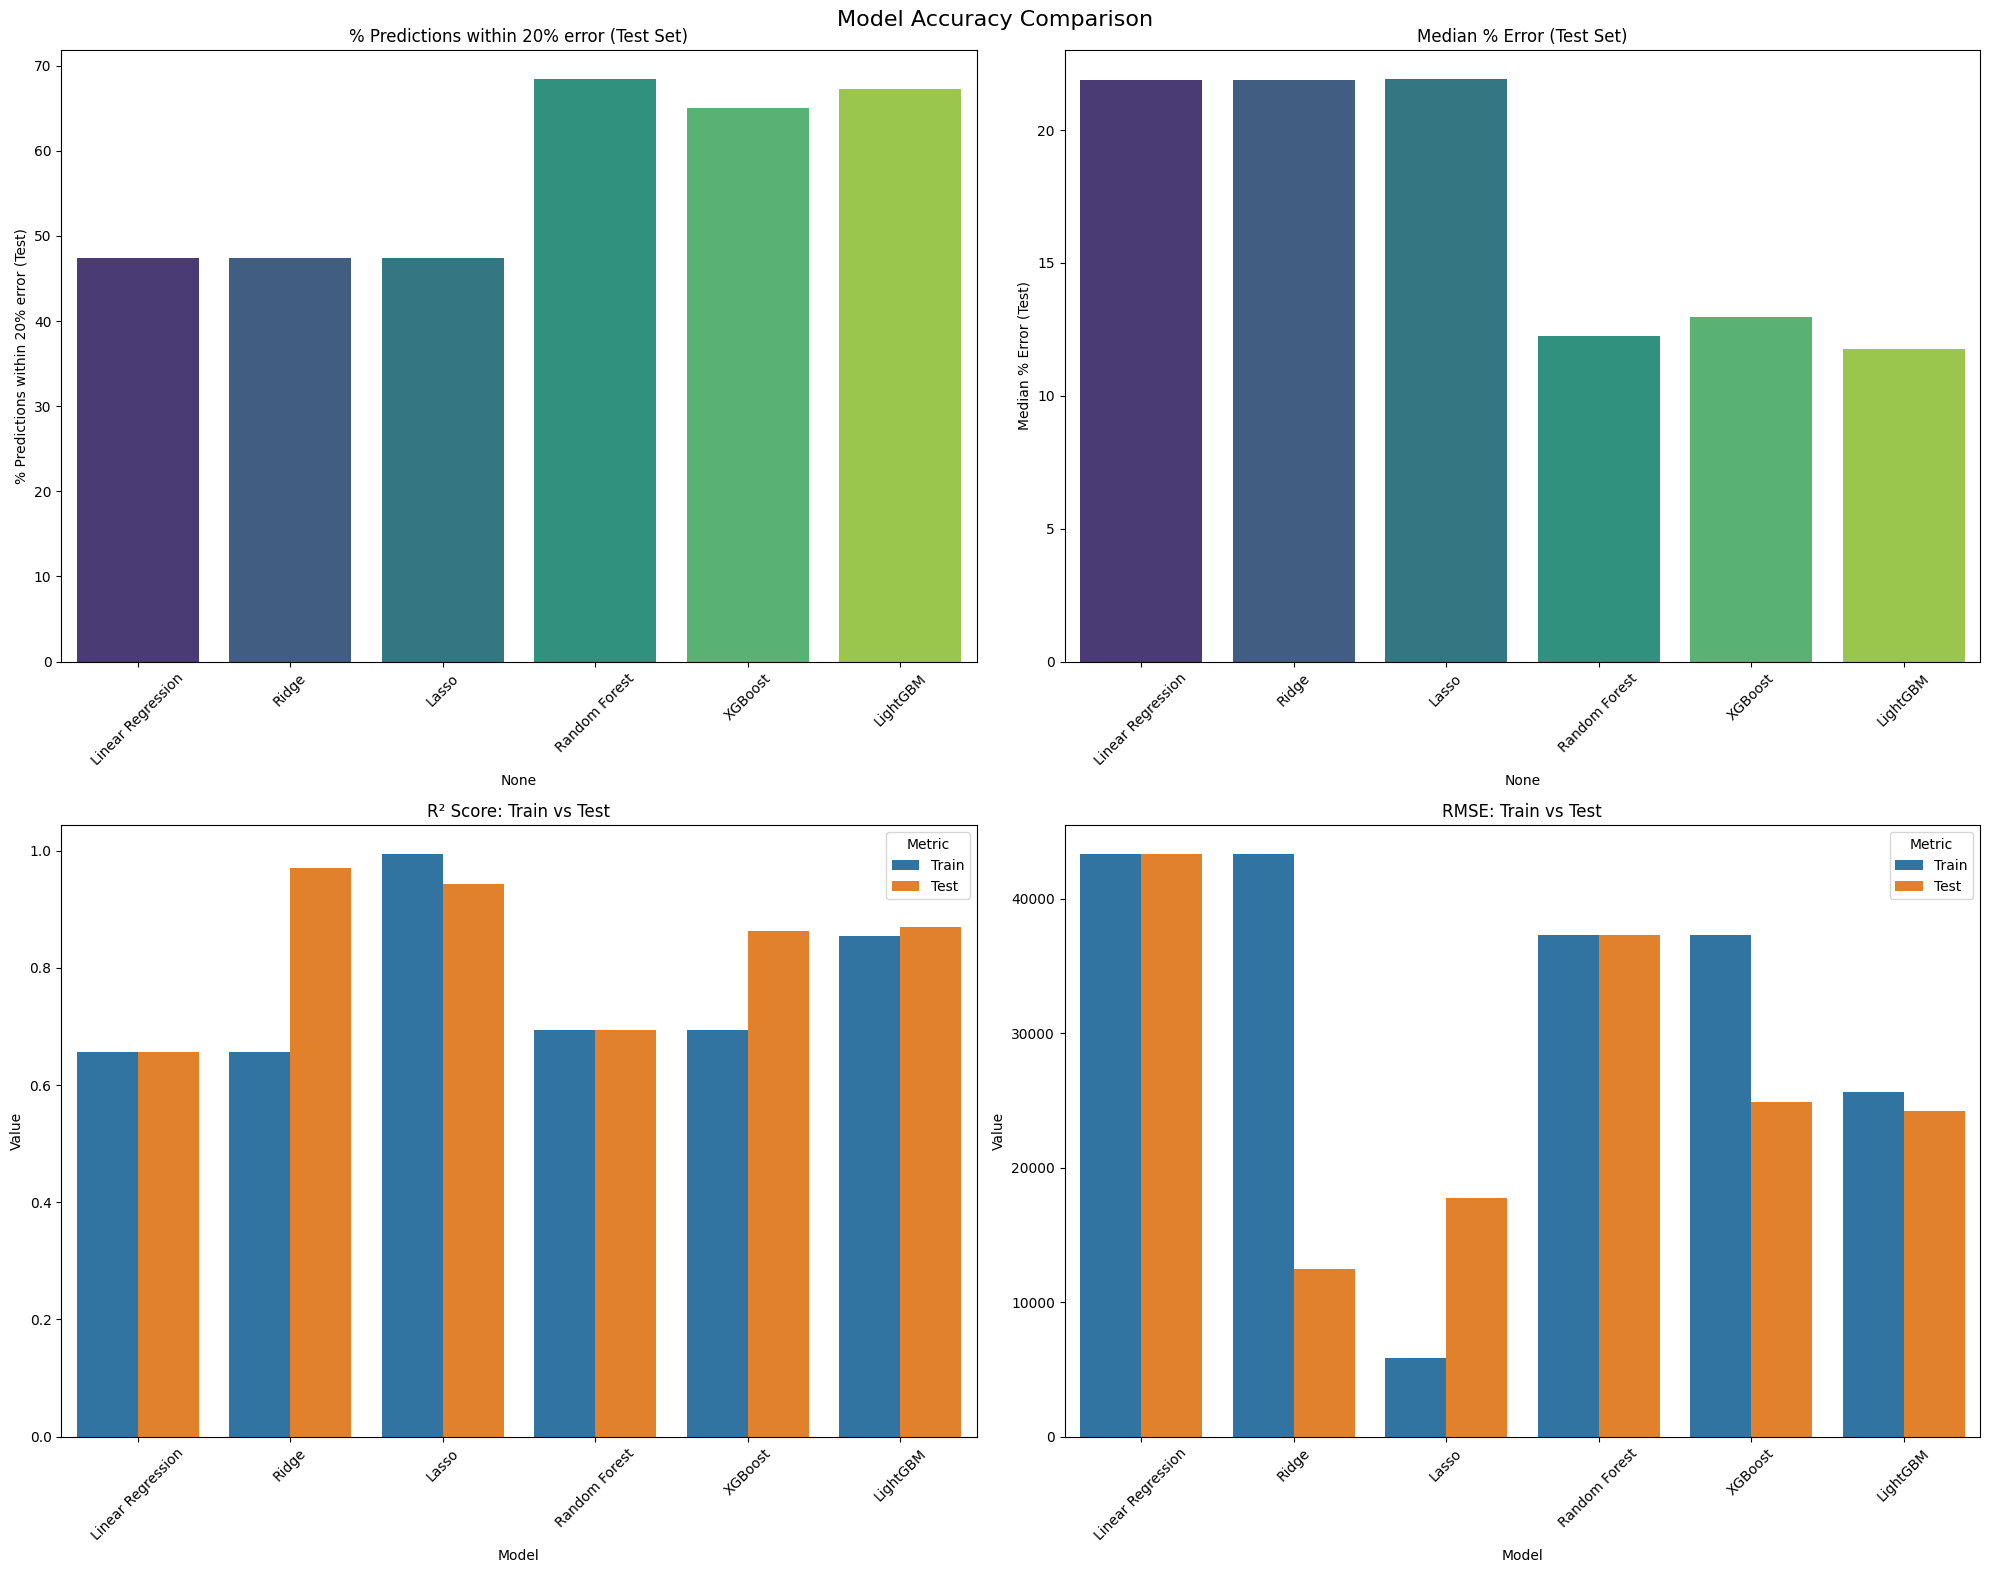

In [435]:
plot_model_accuracy(results_df)

## Results

From the results, we can see that the `XGBoost` model has the best performance:
1. Highest R² score -> means it explains the variance of the price the highest, i.e. 83%
2. Lowest RMSE (lower is better)
3. Lowest MAE (lower is better)
4. Fastest training time

We'll choose the `XGBoost` as our final model, since it has a good balance between performance and training time.